# Transfer Learning with DistilBERT 

### Introduction

This notebook walks through an example of using DistilBERT and transfer learning for sentiment analysis. I start by setting a goal, laying out a plan, and scraping the data before moving on to model training, and finally cover some analysis of the results. The idea is to follow the project from beginning to end, so that the whole data science process is illustrated. As many data scientists know, machine learning is about 10% actual machine learning, and 90% other. I hope that this in-depth description of my project illustrates that point. 
https://www.mountainproject.com/

### The Goal of This Project

When I’m not cleaning data, or analyzing data, or learning about data, or daydreaming about data, I like to spend my time rock climbing. Luckily for me, there is a great website called MountainProject.com, which is an online resource for climbers. The main purpose of Mountain Project is to serve as an online guidebook, where each climbing route has a description, as well as information about the quality, difficulty, and type of climb. There are also forums where climbers can ask questions, learn new techniques, find partners, brag about recent climbing adventures, and review climbing gear.

The climbing gear reviews are really helpful for me as a climber when I am trying to decide what kind of gear I want to buy next. It occurred to me that climbing gear companies may want to know what climbers think of their brand, or of a particular piece of gear that they make. Thus, this project was born.

The goal of this project is to label the sentiment of the gear review forums as positive, negative, or neutral. The question is: “How do climbers feel about different kinds of climbing gear?” More broadly, the goal of this project is to create a model that can label the sentiment of an online forum in a niche community using limited training data. Although this project is focused on the rock climbing community, the methods described here could easily be used in other domains as well. This could be useful for the participants in a given community who want to know the best techniques and buy the best gear. It would also be useful for companies that supply products for that industry; it would be useful for these companies to know how users feel about their products, and which keywords participants are using when they make a positive or negative comment about the product.


### The Plan

Unfortunately for me, the Mountain Project gear review forums are not labeled. The forums are a collection of thoughts and opinions, but there is no numerical value associated with them. By that I mean, I can write what I think about a piece of gear, but I don’t give it a star rating. This eliminates the possibility of direct supervised learning. (Yeah, sure, I could go and label the 100k+ forums by hand, but where is the fun in that? Nowhere, that sounds awful.)

Enter transfer learning. Transfer learning is when a model trained on one task is used for a similar task. In this case, I have an unlabeled dataset and I want to assign labels to it. So, I need to create a model that is trained to predict labels on a labeled dataset, then use that model to create labels for my unlabeled forum dataset.

Because this model will need to analyze natural language, I need my model to first understand language. This is why I am use a DistilBERT model*. The details about how DistilBERT works are beyond the scope of this article, but can be found in this description of BERT and this description of DistilBERT. Put simply, DistilBERT is a pretrained LSTM model that understands English. After loading the DistilBERT model, it can be fine-tuned on a more specific dataset. In this case, I want to tune DistilBERT so that it can accurately label climbing gear forums.

Thus, there will be two transfers of learning; first, knowledge contained in DistilBERT will be transferred to my labeled dataset. Then, I will train this model to label the sentiment of data. Second, I will transfer this model to my unlabeled forum dataset. This will allow my model to label that dataset. After the forum dataset is labeled with positive, negative, or neutral sentiment, I can run an analysis on what climbers think about different types of climbing gear.

### The Data

The closer your initial task is to your final task, the more effective transfer learning will be. So, I need to find a labeled dataset related to climbing and climbing gear. My search led me to two places. First, to Trailspace.com. Trailspace is a website where outdoor enthusiasts can write reviews about their gear, and (most importantly) leave a star rating. This seemed perfect, but sadly there were only ~1000 reviews related to climbing gear.

This lack of data led me to my second labeled dataset: the routes on Mountain Project. Each route has a description and a star rating, and there are ~116,000 routes on the website. That is plenty of data, but the data isn’t exactly what I need because the way climbers talk about routes is different from the way climbers talk about gear. For example, I wouldn’t describe gear as “fun”, and I wouldn’t describe a route as “useful”.

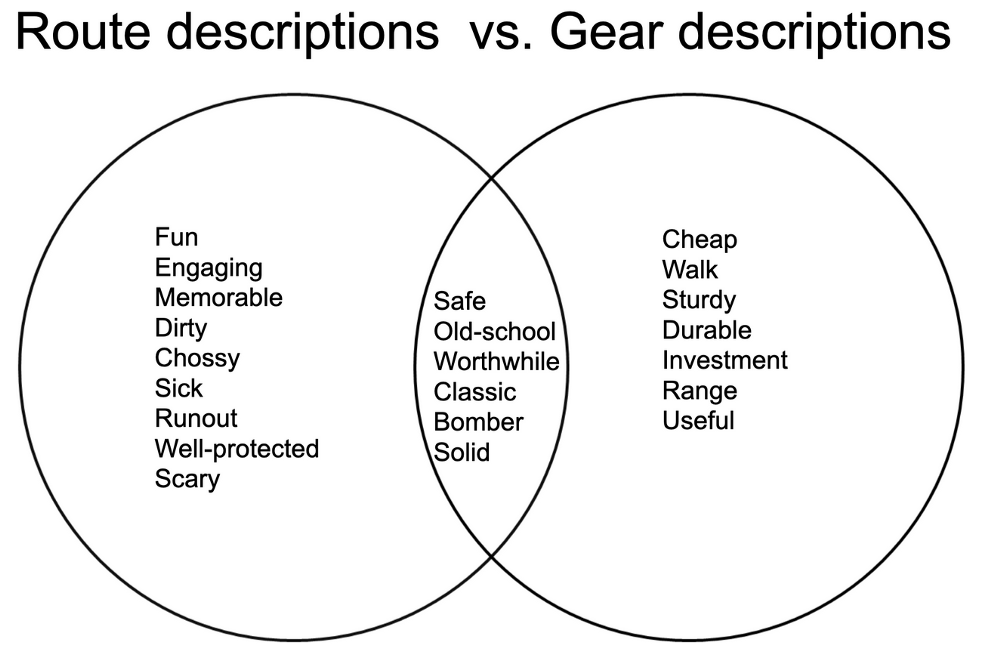

Still, I think it will be better to train on route data than nothing because there is some overlap in the way climbers talk about anything, and the vernacular is quite unique with a lot of slang. For example, if I describe a route as “a sick climb with bomber gear” then the climb is high-quality. The hope is that my model will learn this unique climbing vocabulary and apply it to the gear review forums when it comes time to label them.

## Step One: Scrape the Data

My plan is laid out, and now it is time to actually gather some data. To do this, I needed to create a web scraper for Mountain Project and Trailspace. Prior to starting this project, I had no idea how to do any kind of web scraping. So, I watched this extremely helpful YouTube video about web scraping in Python using BeautifulSoup. Luckily for me, both Trailspace and the Mountain Project forums were quite easy to scrape. The code for the Trailspace scraping is below, as an example:

In [ ]:
from urllib.request import urlopen as uReq
from bs4 import BeautifulSoup as soup
import os
import time
%%capture
from tqdm import tqdm_notebook as tqdm
tqdm().pandas()# Manually gather list of main page URLs
all_urls = ["https://www.trailspace.com/gear/mountaineering-boots/",
           "https://www.trailspace.com/gear/mountaineering-boots/?page=2",
           "https://www.trailspace.com/gear/mountaineering-boots/?page=3",
           "https://www.trailspace.com/gear/approach-shoes/",
           "https://www.trailspace.com/gear/approach-shoes/?page=2",
           "https://www.trailspace.com/gear/climbing-shoes/",
           "https://www.trailspace.com/gear/climbing-shoes/?page=2",
           "https://www.trailspace.com/gear/climbing-protection/",
           "https://www.trailspace.com/gear/ropes/",
           "https://www.trailspace.com/gear/carabiners-and-quickdraws/",
           "https://www.trailspace.com/gear/belay-rappel/",
           "https://www.trailspace.com/gear/ice-and-snow-gear/",
           "https://www.trailspace.com/gear/big-wall-aid-gear/",
           "https://www.trailspace.com/gear/harnesses/",
           "https://www.trailspace.com/gear/climbing-helmets/",
           "https://www.trailspace.com/gear/climbing-accessories/"]

# Define a function to get URLs
def get_gear_subpages(main_url):    
    '''Function to grab all sub-URLs from main URL'''    
    # Get HTML info
    uClient = uReq(main_url) # request the URL
    page_html = uClient.read() # Read the html
    uClient.close() # close the connection
    gear_soup = soup(page_html, "html.parser")


    item_urls = []
    items = gear_soup.findAll("a", {"class":"plProductSummaryGrid"})
    for a_tag in items:
        href = a_tag.attrs.get("href")
        if href == "" or href is None:
            continue
        else:
            item_urls.append("https://www.trailspace.com"+href)

    return item_urls

# Get a lit of all sub-URLs
all_sub_urls = []
for main_url in tqdm(all_urls):
    all_sub_urls += get_gear_subpages(main_url)

# Define function to scrape data
def get_gear_comments(gear_url):    
    '''Function to extract all comments from each sub-URL'''
    # Get HTML info
    uClient = uReq(gear_url) # request the URL
    page_html = uClient.read() # Read the html
    uClient.close() # close the connection
    review_soup = soup(page_html, "html.parser")
    
    all_reviews = review_soup.find("div", {"id":"reviews"})
    
    review_dict = dict()
    
    try:
        for this_review in all_reviews.findAll("div", {"class": "reviewOuterContainer"}):
            # Get review rating
            try:
                rating = float(str(this_review.find_next('img').find_next("img")).split("rated ")[1].split(" of")[0])
            except:
                rating = float(str(this_review.find("img").find_next("img").find_next("img")).split("rated ")[1].split(" of")[0])
            # Get review text
            review_summary = this_review.find("div",{"class":"review summary"}).findAll("p")
            review_text = ""
            for blurb in review_summary:
                review_text += "   " + blurb.text.replace("\n", "   ").replace("\r", "   ")

            review_dict[review_text] = rating
    except:
        pass
    
    return review_dict


# Extract information from all URLs and save to file:
t0 = time.time()
filename = "trailspace_gear_reviews.csv"
f = open(filename, "w")
headers = "brand, model, rating, rating_text\n"
f.write(headers)
   
for url in tqdm(all_sub_urls):
    brand = url.split("/")[4]
    model = url.split("/")[5]
    info = get_gear_comments(url)
    for review in info.keys():
        rating_text = review.replace(",", "~")
        rating = info[review]

        f.write(brand  +","+ 
                model  +","+ 
                str(rating) +","+ 
                rating_text  + "\n")
        
f.close()
t1 = time.time()  
t1-t0

The routes proved to be much more challenging. On Mountain Project, routes are sorted by “area > subarea > route”. But sometimes, there are multiple subareas, so it looks like “area > big-subarea > middle-subarea > small-subarea > route”. My main problem was iterating over all of the routes to ensure I gathered data about all of them, even though they are not uniformly organized.

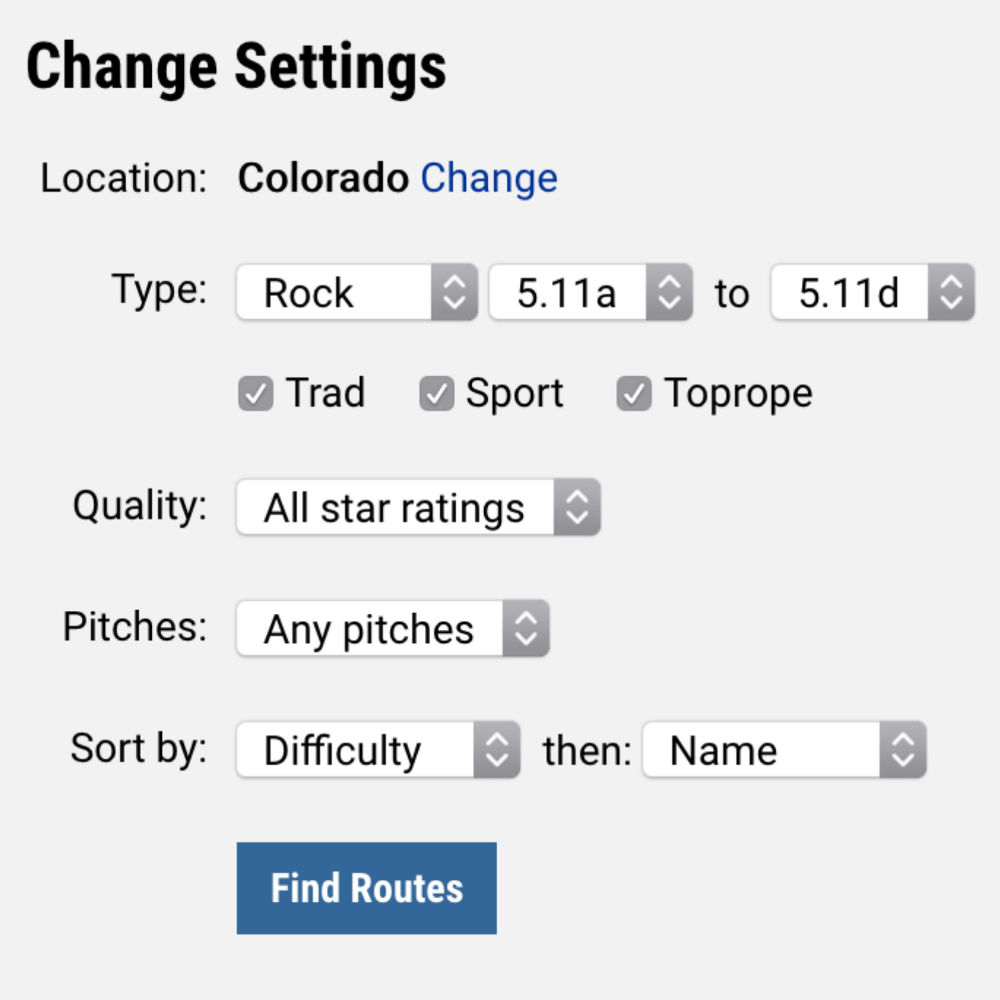

Thankfully, Mountain Project had another way around this. Within Mountain Project you can search for routes and sort them by difficulty, then by name. It will then output a lovely csv file that includes the URL for each route in your search results. Unfortunately, the search maxes out at 1000 routes, so you can’t get them all in one go. Not to be deterred by such a small inconvenience, I painstakingly went through each area and subarea, grabbed 1000 routes at a time, and saved the files to my computer until I had all 116,000 routes saved in separate csv files on my computer. Once I had all the csv files, I combined them with this code:

In [ ]:
import os
import glob
import pandas as pd
from progress.bar import Bar
import time
import tqdm

# Combine CSVs that I got directly from Mountain Project
extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])

#export to csv
combined_csv.to_csv( "all_routes.csv", index=False, encoding='utf-8-sig')
routes = pd.read_csv("all_routes.csv")
routes.drop_duplicates(subset = "URL", inplace = True)

# remove routes with no rating
routes = routes[routes["Avg Stars"]!= -1]

At this point, I have a large csv file that has the URLs of all the routes on Mountain Project. Now, I need to iterate over each URL and scrape the information I need, then add it back to this csv. Routes with empty descriptions, non-English descriptions, or fewer than 10 votes** were removed. This cut my number of route examples down to about 31,000.

In [ ]:
def description_scrape(url_to_scrape, write = True):
    """Get description from route URL"""

    # Get HTML info
    uClient = uReq(url_to_scrape) # request the URL
    page_html = uClient.read() # Read the html
    uClient.close() # close the connection
    route_soup = soup(page_html, "html.parser")
    
    # Get route description headers
    heading_container = route_soup.findAll("h2", {"class":"mt-2"})
    heading_container[0].text.strip()
    headers = ""
    for h in range(len(heading_container)):
        headers += "&&&" + heading_container[h].text.strip()
    headers = headers.split("&&&")[1:]
    
    # Get route description text
    route_soup = soup(page_html, "html.parser")
    desc_container = route_soup.findAll("div", {"class":"fr-view"})
    words = ""
    for l in range(len(desc_container)):
        words += "&&&" + desc_container[l].text
    words = words.split("&&&")[1:]
    
    # Combine into dictionary
    route_dict = dict(zip(headers, words))
    
    # Add URL to dictionary
    route_dict["URL"] = url_to_scrape
    
    # Get number of votes on star rating and add to dictionary
    star_container = route_soup.find("span", id="route-star-avg")
    num_votes = int(star_container.span.span.text.strip().split("from")[1].split("\n")[0].replace(",", ""))
    route_dict["star_votes"] = num_votes
    
    if write == True:
        # Write to file:
        f.write(route_dict["URL"] +","+ 
                route_dict.setdefault("Description", "none listed").replace(",", "~") +","+
                route_dict.setdefault("Protection", "none listed").replace(",", "~") +","+
                str(route_dict["star_votes"]) + "\n")
    else:
        return route_dict# Get URLs from large route.csv file
    
    
all_route_urls = list(routes["URL"]) # where routes is the name of the dataframe

# Open a new file
filename = "route_desc.csv"
f = open(filename, "w")
headers = "URL, desc, protection, num_votes\n"
f.write(headers)# Scrape all the routes
for route_url in tqdm(all_route_urls):
    description_scrape(route_url)
    time.sleep(.05)

t1 = time.time()
t1-t0

f.close()


# Merge these dataframes:
merged = routes.merge(route_desc, on='URL')
merged.to_csv("all_routes_and_desc.csv", index=False)
df = pd.read_csv("all_routes_and_desc.csv")


##### CLEANING STEPS #####

# Drop column that shows my personal vote
df.drop(["Your Stars"], axis = 1, inplace=True)

# Removes whitespace around column names
df_whole = df.rename(columns=lambda x: x.strip()) 

# Combine text columns and select needed columns
df_whole["words"] = df_whole["desc"] + " " + df_whole["protection"]
df = df_whole[["words", "num_votes", "Avg Stars"]]

# Remove rows with no description
bad_df = df[df.words.apply(lambda x: len(str(x))<=5)]
new_df = df[~df.words.isin(bad_df.words)]
print(len(df), len(bad_df), len(new_df), len(df)-len(bad_df)==len(new_df))
df = new_df

# Remove non-english entries... takes a few minutes...
from langdetect import detect
def is_english(x):
    try:
        return detect(x)
    except:
        return None

df["english"] = df['words'].apply(lambda x: is_english(x) == 'en')
df = df[df.english]
df = df[["words", "num_votes", "Avg Stars"]]

# Now remove rows with less than 10 votes
few_votes = np.where(df.num_votes <= 9)[0]
for vote in few_votes:
    try:
        df.drop(vote, inplace = True)
    except:
        pass
df_small = df.drop(few_votes)
df = df_small

# Save it
df.to_csv('data/words_and_stars_no_ninevotes.csv', index=False, header=True)

Now, I have three datasets to work with: Trailspace.com gear reviews, Mountain Project routes, and Mountain Project gear review forums.

One problem with the gear review forums is that there are often multiple sentiments about multiple pieces of gear in the same forum posting. So, in a naive attempt to split the forum posts into sentences, I split each posting every time there was a period. There are many reasons why this is not the best way to split text into sentences, but I assumed that it would be good enough for this project. This increased the number of samples to about 200,000.

## Step Two: Build a Model

If you have made it this far, rejoice, because it is time for some actual machine learning! Well, almost time. Before I can begin building a model, I need to have some kind of metric to measure the quality of my model. This means I had to take on the dreaded task of labelling some of the forums by hand. I manually labeled 4000 samples of the forums as positive (2), negative (0), or neutral (1), so that I could evaluate my model. This took about four hours.

Of course, I want to build the best possible model for my task. I have two datasets to help me create this model. The Trailspace data is small, but more relevant. The route data is large, but less relevant. Which one will help my model more? Or, should I use a combination of both? And, importantly, does the additional data provide better performance than a simple DistilBERT model?

I decided to do a comparison of four models:

    1. A model with DistilBERT only
    2. A model with DistilBERT and route information
    3. A model with DistilBERT and Trailspace information
    4. A model with DistilBERT and both datasets

On top of each DistilBERT is a small, identical neural network. This network is trained on 4000 labeled forum examples with a random seed set to 42 to prevent variation in the way the data is split. The lower DistilBERT layers were locked, meaning DistilBERT was not re-trained by the forum data. By keeping the networks identical, the only variation between the models is the dataset (or lack thereof) on which DistilBERT was tuned. This will allow me to conclude which dataset did the best at tuning DistilBERT for predicting forum post labels, without introducing noise from different types of models or variation in data split. Because there are three categories (positive, negative, and neutral), categorical cross-entropy was used as a loss function.

After a great deal of experimenting and tweaking parameters, I found that the best way to train the DistilBERT only model is the method below:

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

from sklearn.model_selection import train_test_split

import tensorflow as tf

import pandas as pd
import numpy as np

classifier = pipeline('sentiment-analysis')

import random
random.seed(42)


##### SET UP THE MODEL #####
save_directory = "distilbert-base-uncased"
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') # Build model that will go on top of DistilBERT
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])


##### LOAD THE TEST DATA #####
df = pd.read_csv('data/labeled_forum_test.csv')
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["sentiment"], test_size=0.20, random_state=42)# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X_train = tokenizer(
     list(X_train),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

X_test = tokenizer(
     list(X_test),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
 )

# Create Y values
y_train = pd.get_dummies(y_train)
y_test = pd.get_dummies(y_test)

#### TRAIN THE MODEL ####
history = model.fit([X_train["input_ids"],   X_train["attention_mask"]], 
          y_train, 
          batch_size=128, 
          epochs=8, 
          verbose=1, 
          validation_split=0.2)


#### SAVE WEIGHTS FOR LATER ####
model.save_weights('models/final_models/bert_only2/bert_only2')

The code above creates the baseline model, DistilBERT only. Now, I will tune DistilBERT with the data I saved to ‘data/words_and_stars_no_ninevotes.csv’.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel

import tensorflow as tf
import numpy as np

classifier = pipeline('sentiment-analysis')


##### LOAD DATA THAT WILL TUNE DISTILBERT #####
df = pd.read_csv('data/words_and_stars_no_ninevotes.csv')
df.replace(4,3.9999999) # prevents errors


#### TUNE DISTILBERT #####
# normalize star values
df["norm_star"] = df["Avg Stars"]/2
df.head()

# drop null entries
print(len(np.where(pd.isnull(df["words"]))[0])) # 288 null entries
df.dropna(inplace = True)

model_name = "distilbert-base-uncased"
tf_model = TFAutoModelForSequenceClassification.from_pretrained(model_name)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

tf_batch = tokenizer(
     list(df["words"]),
     padding=True,
     truncation=True,
     return_tensors="tf"
 )

tf_outputs = tf_model(tf_batch, labels = tf.constant(list(df["norm_star"]), dtype=tf.float64))

loss = [list(df["norm_star"])[i]-float(tf_outputs[0][i]) for i in range(len(df))]
star_diff = (sum(loss)/1000)*4
star_diff

# Save the tuned DistilBERT so you can use it later
save_directory = "models/route_model"
tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

From here, the code to create a model that has a tuned DistilBERT at its base is the same as the code used to create the DistilBERT only model, except instead of `save_directory = "distilbert-base-uncased"`, use `save_directory = "models/route_model"`. After experimentation and parameter tweaking, the results for the four models looks like this:
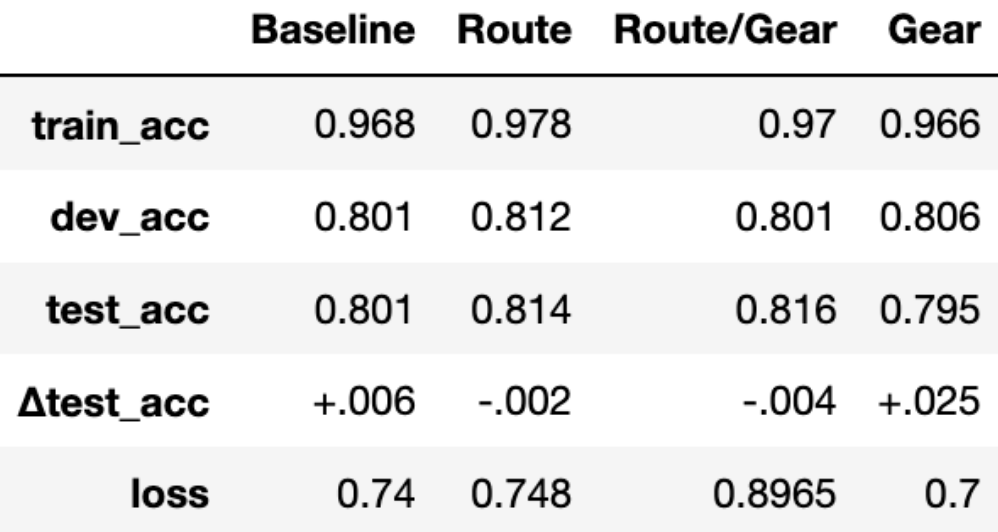

The DistilBERT model with both route and gear data provided the best test accuracy at 81.6% for three way classification, and will be used to label the Mountain Project forums.

## Step Three: Model Analysis

The route and gear model provided a test accuracy of 81.6%. This begs the question: what is happening in the other 18.4%? Could it be the length of the post that is causing inaccuracy?

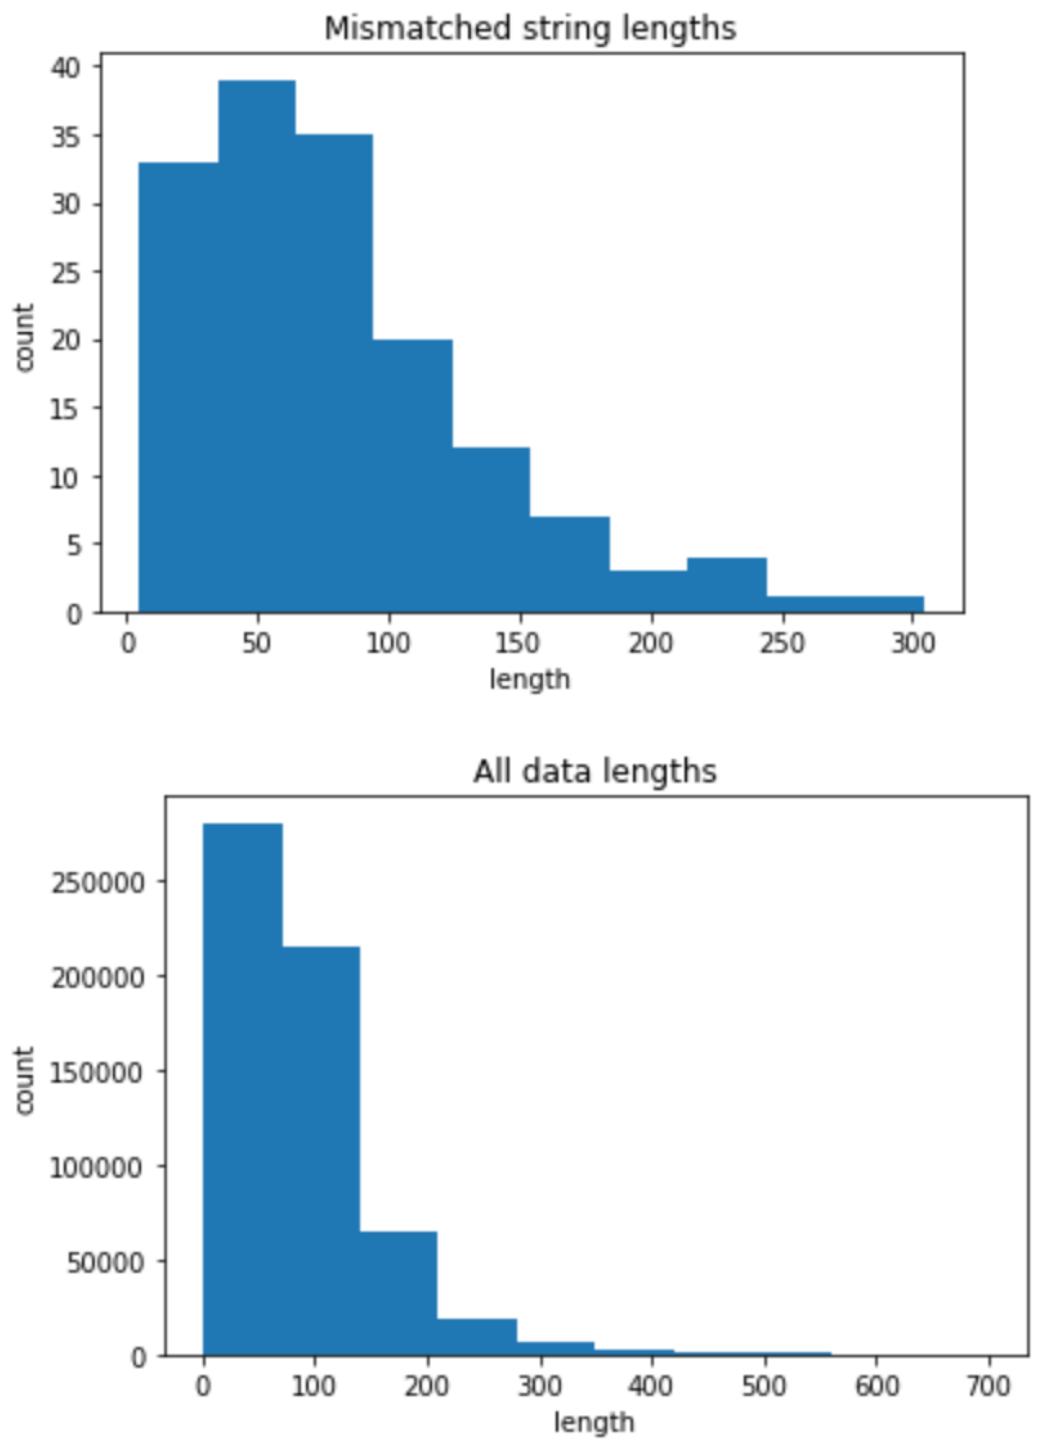

An initial look at string lengths does not show that the lengths of the mismatched strings are terribly different from the lengths of the whole dataset, so this is unlikely to be the culprit.

Next, I looked at the counts of words that were mislabeled compared to the counts of words correctly labeled, both with and without stop words. In each, the counts looked similar except for two words: “cam” and “hex”. Posts with these words tended to be mislabeled. These each refer to a type of climbing gear, and I think they are mislabeled for different reasons.

Hexes are “old-school” gear that work, but are outdated. Therefore, people don’t really buy them anymore and there are a lot of mixed feelings in the forums about whether or not they are still useful. This may have confused the model when it comes to classifying sentiment when the subject is hexes.

When there is a big sale on gear, people often post about it in the forums. As I was labeling data, if the post was simply “25% off on cams at website.com”, I labeled it as neutral. Cams are expensive, they go on sale frequently, and climbers need a lot of them, so sales on cams are posted frequently; all of these postings were labeled as neutral. There is also a lot of debate about the best kind of cams, which can lead to sentences with multiple sentiments, causing the label to come out as neutral. Additionally, people talk about cams in a neutral way when the recommended gear for a specific climb. I think that these things led my model to believe that cams are almost always neutral.

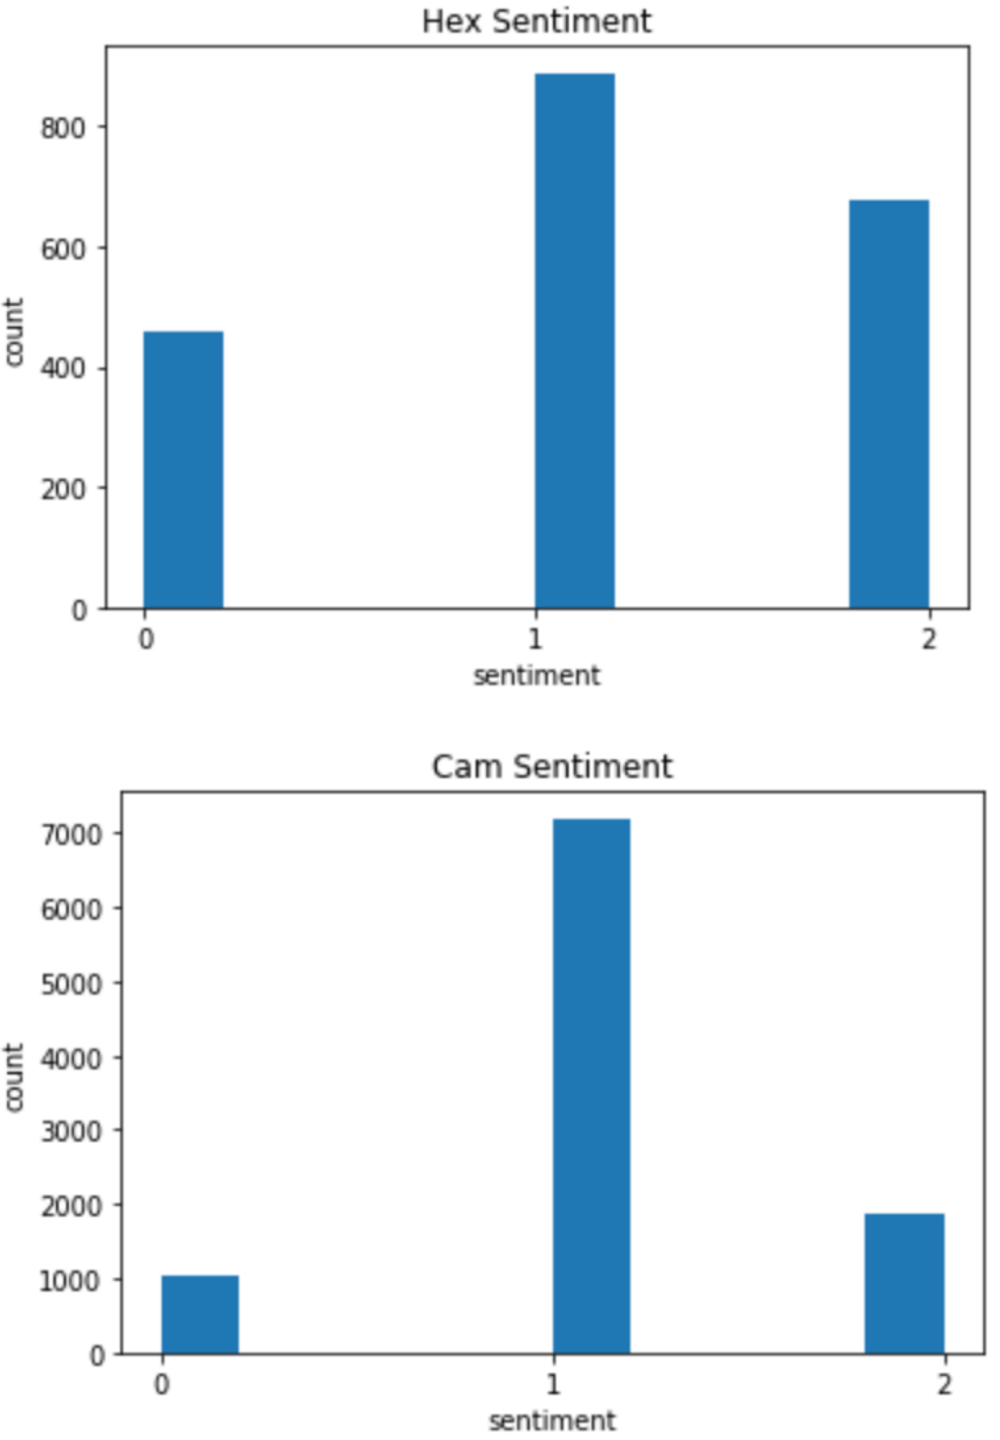

Sentiment about hexes is quite controversial. Sentiment about cams are more often listed as neutral. Notice the difference in the number of examples; cams are far more popular than hexes.

In sum, my model confuses sentiment in the following cases:

   1. When there is a sale mentioned: “25% off Black Diamond cams, the best on the market” true: 2, label: 1
   2. When the post is not directly related to climbing: “The republican party does not support our use of public land” true: 0, label: 1 (I suspect this is because my model is not trained for it)
   3. When parallel cracks are mentioned: “Cams are good for parallel cracks” true: 2, label: 0 (I suspect this is because cams are the only kind of gear that work well in parallel cracks. Most posts say things like “tricams are good unless it is a parallel crack.”)
   4. When hexes are mentioned: “Hexes are fine for your first rack.” true: 2, label: 0

With this project, I had hoped to determine if a large, less relevant dataset is better than a smaller, more relevant dataset for analyzing sentiment on a niche online forum. My model that had the most training examples performed the best. However, it is unclear whether this is due to the additional examples being more relevant, or if it is simply due to more examples.

I have additional route data (the routes with 9 or fewer votes). Although I suspect that this data may be less reliable, it could be useful in follow-up experiments. I could train models on only route data of different sizes, up to the 116,700 examples that I scraped, then compare. This would tell me if the additional accuracy was solely due to more data, or if the specificity of the small gear dataset helped.

Although it cannot be concluded that inclusion of a smaller but more relevant labeled data improves the model, it can be concluded that more data is indeed better than less, even if the larger dataset is a little bit less relevant. This is evidenced by the comparison of the gear only and route only models. However, the relevance of the gear dataset may or may not have improved the final model; further experimentation is needed to make that conclusion.

## Step Four: Analyze Results

Finally, it is time to label the forums so that I can run some analysis on them and see how climbers really feel about gear.

In [ ]:
from transformers import pipeline
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from transformers import DistilBertTokenizer, DistilBertModel, DistilBertConfig, TFAutoModelWithLMHead, TFAutoModel, AutoModel
from transformers import PreTrainedModel

from sklearn.model_selection import train_test_split

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

classifier = pipeline('sentiment-analysis')

import random
random.seed(42)

%matplotlib inline

#### RERUN YOUR MODEL #####
save_directory = "models/route_model"
config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAutoModel.from_pretrained(save_directory, from_pt=True, config = config)

input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')

# Build model that will go on top of DistilBERT
embedding_layer = transformer_model(input_ids_in, attention_mask=input_masks_in)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(embedding_layer)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation='relu')(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(3, activation='sigmoid')(X)
tf.keras.layers.Softmax(axis=-1)
model = tf.keras.Model(inputs=[input_ids_in, input_masks_in], outputs = X)

for layer in model.layers[:3]:
    layer.trainable = False
    
model.compile(optimizer="Adam", loss=tf.keras.losses.CategoricalCrossentropy(), metrics=["acc"])


#### LOAD THE WEIGHTS THAT YOU TRAINED BEFORE AND PREP DATA #####
model.load_weights('models/final_models/route_only2/route_only2')# read in data
df = pd.read_csv('data/all_forums.csv')# Create X values
tokenizer = AutoTokenizer.from_pretrained(save_directory)
X = tokenizer(
     list(df["text"]),
     padding=True,
     truncation=True,
     return_tensors="tf",
     max_length = 128
    )preds = model.predict([X["input_ids"], X["attention_mask"]])

#### ADD PREDICTIONS TO THE DATAFRAME #####
# Start with the first 5000, then replace the first n rows of the df
# For some reason, the merge works better this way.
# Add predicted labels to df
pred_labels = [np.argmax(preds[i], axis = 0) for i in range(len(preds))]
df_small = df.copy()

df_small = df_small[:5000] # remove in full set
df_small["pred_label"] = pred_labels[:5000] # add predicted labels
df_small["text"] = df_small["text"].str.strip().str.lower() # lower and strip whitespace

# remove empty rows
df_small['text'].replace('', np.nan, inplace=True)
df_small.dropna(subset=['text'], inplace=True)

#clean index mess
df_small.reset_index(inplace = True) 
df_small.drop(["index"], axis = 1, inplace = True)

# Get labeled dataframe
labeled_df = pd.read_csv("data/labeled_forum_test.csv")
labeled_df["text"] = labeled_df["text"].str.strip().str.lower()

# Now merge
new_df = df_small.merge(labeled_df, how = 'left', on = "text")
print(len(new_df))
print(len(new_df)-len(df_small))

# Now get big DF and replace the first n rows
# Add predicted labels to df
pred_labels = [np.argmax(preds[i], axis = 0) for i in range(len(preds))]
full_df = df.copy()

full_df["pred_label"] = pred_labels # add predicted labels
full_df["text"] = full_df["text"].str.strip().str.lower() # lower and strip whitespace

# remove empty rows
full_df['text'].replace('', np.nan, inplace=True)
full_df.dropna(subset=['text'], inplace=True)

#clean index mess
full_df.reset_index(inplace = True) 
full_df.drop(["index"], axis = 1, inplace = True)

##### COMBINE THE DATAFRAMES AND SAVE #####

# Combine df_small and full_df[len(new_df):]
df_full = new_df.append(full_df[len(new_df):])
df_full = df_full.rename(columns={"sentiment": "true_label"})
df_full.reset_index(inplace = True) 
df_full.drop(["index"], axis = 1, inplace = True)
df_full.to_csv('data/full_forum_labeled.csv', index = False)

From here, further analysis can be done, depending on what exactly you want to know. Below are some examples of what you could do next. I am picking on Mammut a little bit because I just bought a Mammut backpack based on a Mountain Project recommendation.

#### Do climbers write mostly positive, negative, or neutral reviews of gear?

It appears that most posts are neutral. This makes sense because climbers are often talking about sales, or recommending gear for a specific climb, both of which I labeled as neutral.

(array([ 39398.,      0.,      0.,      0.,      0., 479947.,      0.,
             0.,      0.,  69391.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

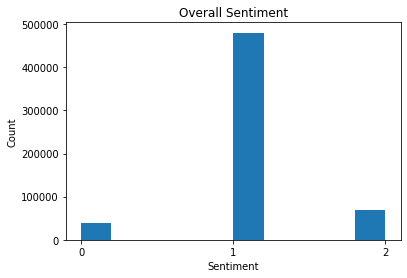

In [12]:
df = pd.read_csv('/Users/patriciadegner/Documents/MIDS/DL/final_project/data/full_forum_labeled.csv')
plt.title("Overall Sentiment")
plt.ylabel('Count')
plt.xlabel('Sentiment')
plt.xticks([0,1,2])
plt.hist(df.pred_label)

#### Has sentiment about Mammut changed over time?

It appears that sentiment about Mammut has not changed much over time.

/Users/patriciadegner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<BarContainer object of 15 artists>

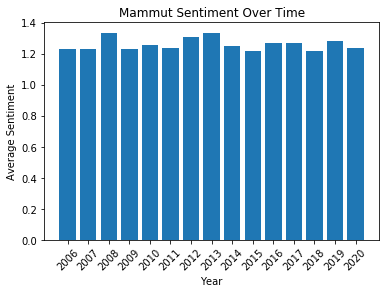

In [14]:
# Generate dataframe
mammut_df = df[df.text.str.contains("mammut").fillna(False)]
mammut_df["post_year"] = [mammut_df.post_date[i][-4:] for i in mammut_df.index]
mammut_grouped = mammut_df.groupby(["post_year"]).mean()

# Create plot
plt.title("Mammut Sentiment Over Time")
plt.ylabel('Average Sentiment')
plt.xlabel('Year')
plt.xticks(rotation=45)
plt.bar(mammut_grouped.index, mammut_grouped.pred_label)

#### Do climbers who joined Mountain Project more recently have different feelings about Mammut than those who joined a long time ago? 

(Account age is being used as a proxy for the number of years spent as a climber; do more experienced climbers have different preferences?)

This graph compares the age of the account to the average sentiment towards Mammut. There does not appear to be a trend but there is more variance in older accounts, so it is hard to say for sure.

/Users/patriciadegner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/patriciadegner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/Users/patriciadegner/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarn

<BarContainer object of 19 artists>

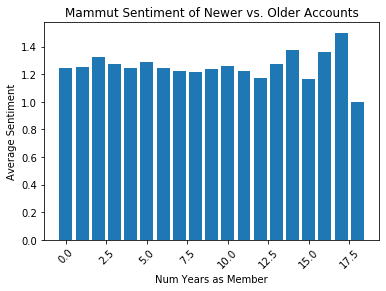

In [15]:
# Generate dataframe
mammut_df = df[df.text.str.contains("mammut").fillna(False)]
mammut_df["post_year"] = [int(mammut_df.post_date[i][-4:]) for i in mammut_df.index]

# Get join dates if available
join_year_list = []
for i in mammut_df.index:
    try:
        join_year_list.append(int(mammut_df.join_date[i][-4:]))
    except:
        join_year_list.append(-1000)

# Add join year and years as memeber before posting columns, remove missing info
mammut_df["join_year"] = join_year_list
mammut_df["years_as_mem_before_posting"] = mammut_df["post_year"] - mammut_df["join_year"]
mammut_df = mammut_df[mammut_df['years_as_mem_before_posting'] < 900]

# groupby
mammut_grouped = mammut_df.groupby(["years_as_mem_before_posting"]).mean()

# Create plot
plt.title("Mammut Sentiment of Newer vs. Older Accounts")
plt.ylabel('Average Sentiment')
plt.xlabel('Num Years as Member')
plt.xticks(rotation=45)
plt.bar(mammut_grouped.index, mammut_grouped.pred_label)

#### Is the variance in the previous graph due to a smaller sample size of older accounts?

There are much fewer older accounts, which is why there is more variance in the graph above at the right end of the graph.

<BarContainer object of 19 artists>

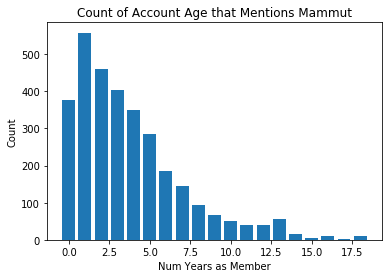

In [16]:
# Groupby
mammut_grouby_count = mammut_df.groupby(["years_as_mem_before_posting"]).count()

# Create plot
plt.title("Count of Account Age that Mentions Mammut")
plt.ylabel('Count')
plt.xlabel('Num Years as Member')
plt.bar(mammut_grouby_count.index, mammut_grouby_count.join_year)

# Conclusion

In this article, I have walked through the steps of a complete machine learning project, including setting a goal, laying out a plan, gathering data, model training and analysis, and analysis of results. Specifically, I have demonstrated, with code, how to use DistilBERT and transfer learning for sentiment analysis on unlabeled data using MountainProject.com as an example. Although I was unable to conclude that a smaller, more relevant dataset is better than a larger, less relevant dataset (or vice versa), I was still able to label the sentiment of rock climbing gear forums and draw some conclusions from the results I found there.

I wrote about this project on Medium: https://medium.com/@pattidegner_7/transfer-learning-example-using-keras-and-distilbert-with-code-e6e725f1fc2d

All of these datasets have been posted on Kaggle.

##### Footnotes

\* *I am using DistilBERT rather than BERT because it is smaller and easier to run on my small, local computer. Although the accuracy is not quite as good as BERT, I assumed it would be good enough for this project. Changing the base model from DistilBERT to BERT would be trivial and result in greater accuracy if needed, but also would require greater computational power.*

\*\* *Why might a route with fewer ratings provide unreliable data?*

*First of all, routes with fewer ratings are more prone to outliers. Route star ratings are purely subjective, and the enjoyment of the route can depend on factors such as strength or height of the climber, how the weather was when the person tried it, how previously climbed routes compare to this one, etc. On any route, one person may think it is terrible, where another loved it. Therefore, the average star rating becomes more reliable as more people vote on it.*

*Second, the first ascent party will often inflate the rating of a route because routes are expensive, in time and money, to put up. Each bolt on a rock climb costs $5 - $10, so a standard sport climb with 10–12 bolts costs around $100 out of the personal pocket of the climber who established it. Each bolt can take fifteen minutes to an hour to place, for a total of three to ten hours per route. A trad climb with no bolts can still be a big investment; a trad climber will be taking on greater risk, since they will not know exactly what gear they will need to safely complete the climb. It also takes time to find a potential new route, and then clear the route of loose rocks, dirt, and other debris. There can be legal problems getting permission to put up rock climbs on private or public land. All of these issues make route establishment a very time-consuming process. The reward for the first ascent party is their name in the guidebook and on Mountain Project, and they get to name the route. However, many first ascent parties want others to climb the routes they put so much effort into. So, the first ascent party will sometimes inflate the star rating on Mountain Project to entice more climbers to try it.*

*On the other hand, sometimes climbers in a small local community do not want their small crag to be swarmed with crowds drawn by lots of high-star climbs. In this case, the climbers may mark good routes as being very bad, to scare away masses of climbers.*

*Finally, there are many “closed projects” listed on Mountain Project. This means that the climb has been found, permission to climb it obtained, and it has been cleaned and bolted (if there are bolts on it), but the climb is very technically difficult and the person who put in the work to establish it has not yet been able to climb it without falling. It is common courtesy to allow the establisher to climb and name the route first, so these climbs will not have any ascents and will have unreliable star ratings.*